In [11]:
import wfdb
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import KFold

import tensorflow as tf, keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

# Data Gathering

This script will download and load all records from '100' to '234' from the MIT-BIH Arrhythmia Database, reshape the ECG signals into windows of 3600 samples, and create a label for each window based on whether it contains any non-normal beats according to the annotations. The data and labels are then concatenated into two large numpy arrays.

In [4]:
# Path to the folder containing the records
folder_path = 'C:\\Users\\jacob\\Desktop\\GitHub\\CS593-ProjectFiles\\Project 3\\ECG Anomoly Detection\\Dataset'

# List of record names
records = [f[:-4] for f in os.listdir(folder_path) if f.endswith('.dat')]

# Initialize empty lists to store the data
data = []
labels = []

# Window size
window_size = 3600

# Loop over all records
for record_name in records:
    try:
        # Load the record and the annotations
        record = wfdb.rdrecord(os.path.join(folder_path, record_name))
        annotation = wfdb.rdann(os.path.join(folder_path, record_name), 'atr')

        # Pad the signal data with zeros until its length is a multiple of the window size
        padded_length = np.ceil(record.p_signal.shape[0] / window_size) * window_size
        padded_signal = np.pad(record.p_signal, ((0, int(padded_length - record.p_signal.shape[0])), (0, 0)))

        # Reshape the padded signal data into windows
        X = np.reshape(padded_signal, (-1, window_size, 2))

        # Create labels for each window based on the annotations
        Y = np.zeros(X.shape[0])
        for i in range(len(annotation.sample)):
            if annotation.symbol[i] != 'N':
                Y[annotation.sample[i] // window_size] = 1

        # Append the data and the labels to the lists
        data.append(X)
        labels.append(Y)
    except:
        print(f"Error loading record {record_name}")

# Concatenate all the data and labels
data = np.concatenate(data)
labels = np.concatenate(labels)

# Data Normalization

The ECG signals should be normalized before they are input to the RNN/LSTM model. This can be done using the StandardScaler class from the sklearn.preprocessing module. This will normalize the ECG signals to have zero mean and unit variance.

In [5]:
# # Calculate the mean and standard deviation of the data
# mean = np.mean(data)
# std = np.std(data)
# 
# # Standardize the data
# data = (data - mean) / std
# 

# Calculate the mean and standard deviation of the data along the last axis (channels)
mean = np.mean(data, axis=(0, 1))
std = np.std(data, axis=(0, 1))

# Standardize the data
data = (data - mean) / std

# Addressing Class Imbalance

## SMOTE (Synthetic Minority Over-sampling Technique)

This will create synthetic samples of the minority class in the training data until the minority class has the same number of samples as the majority class. We can then train the model with X_train_resampled and y_train_resampled instead of X_train and y_train.

We need to make sure that we apply the SMOTE technique only on the training data and not on the validation or test data. This is because by oversampling before the split, information from the validation/test sets would leak into the training set.

In [6]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)

# Further split the training set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Create a SMOTE object
smote = SMOTE()

# Apply SMOTE to your training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# Reshape X_train back to its original shape
X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])

### This is a model that consists of stacked bidirectional long short-term memory (LSTM) layers, dropout layers for regularization, and a time-distributed dense layer.

1. Bidirectional wrapper is used to apply the LSTM layer forwards and then backwards, helping the LSTM to learn long-range dependencies in the sequence data.
- The LSTM layer itself has 64 units
- input_shape=(None, 2) argument indicates that the model can take sequences of arbitrary length (None) with two features per time-step (2)

2. Dropout 20% to prevent overfitting

3. Another bidirectional LSTM layer, again with 64 units and returning sequences

4. Another dropout layer, again dropping out 20% of its inputs

5. The output layer of the model. The TimeDistributed wrapper is used to apply the Dense layer to every time-step of the input sequence independently. The Dense layer itself has a single unit and, by default, no activation function (which means it's a linear activation).

6. The model is compiled with the Adam optimizer and mean squared error loss

In [7]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(None, 2)),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    TimeDistributed(Dense(1))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, None, 128)        34304     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 time_distributed (TimeDistr  (None, None, 1)          129       
 ibuted)                                                         
                                                        

In [8]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val),verbose=1)

Epoch 1/10
163/163 [==============================] - 111s 642ms/step - loss: 0.2592 - val_loss: 0.2437
Epoch 2/10
163/163 [==============================] - 102s 624ms/step - loss: 0.2459 - val_loss: 0.2480
Epoch 3/10
163/163 [==============================] - 102s 623ms/step - loss: 0.2451 - val_loss: 0.2423
Epoch 4/10
163/163 [==============================] - 101s 623ms/step - loss: 0.2454 - val_loss: 0.2449
Epoch 5/10
163/163 [==============================] - 102s 625ms/step - loss: 0.2447 - val_loss: 0.2453
Epoch 6/10
163/163 [==============================] - 103s 634ms/step - loss: 0.2448 - val_loss: 0.2426
Epoch 7/10
163/163 [==============================] - 102s 626ms/step - loss: 0.2447 - val_loss: 0.2459
Epoch 8/10
163/163 [==============================] - 102s 628ms/step - loss: 0.2436 - val_loss: 0.2418
Epoch 9/10
163/163 [==============================] - 104s 637ms/step - loss: 0.2433 - val_loss: 0.2420
Epoch 10/10
163/163 [==============================] - 102s 625m

# Results

55/55 [==============================] - 16s 270ms/step


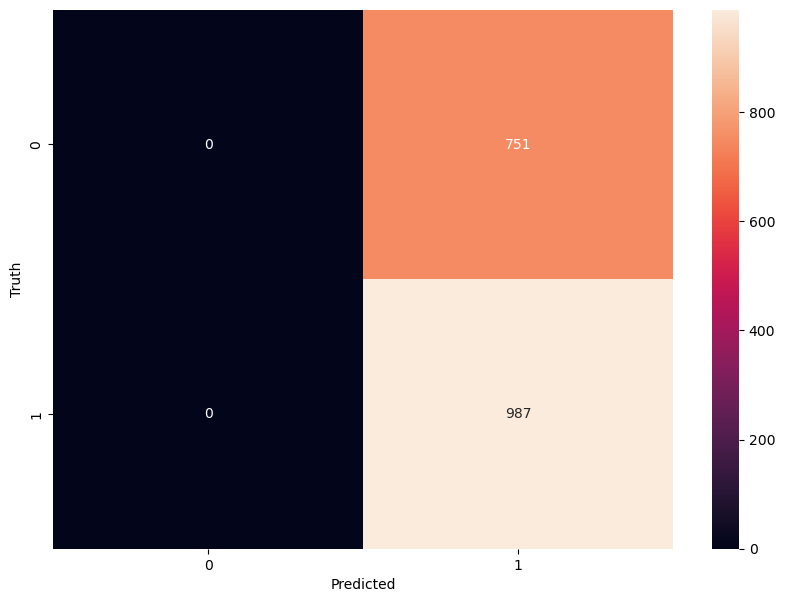

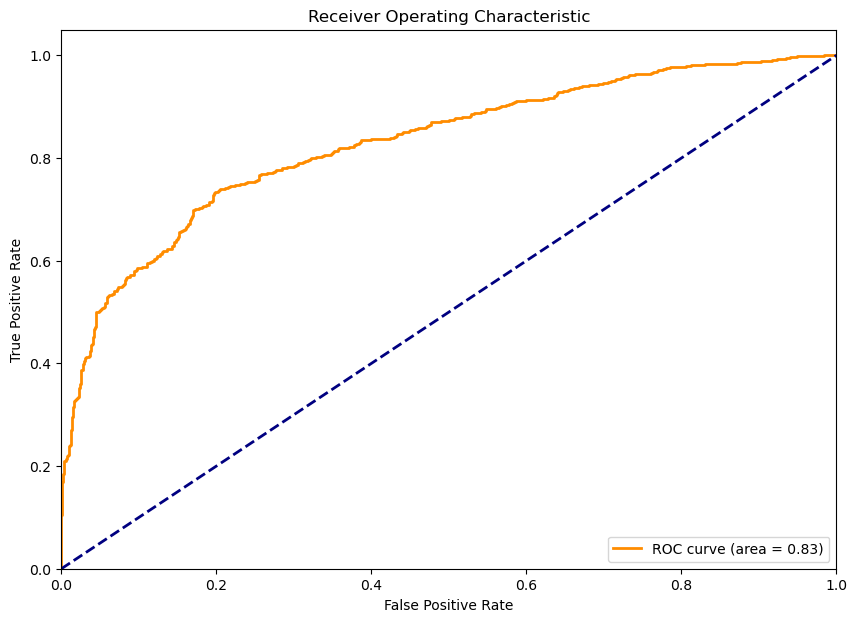

In [9]:
y_pred = model.predict(X_test)
y_pred = y_pred.max(axis=1).flatten()
# The model's output is continuous, but we need binary predictions for the metrics.
# We can choose a threshold (e.g., 0.5) and classify all instances with an output above this threshold as anomalies.
y_pred_bin = (y_pred > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_bin)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC (area under the ROC curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Improve the model training process:

Using the same model just with an improved training process.

Early Stopping: Stop training when the validation loss stops improving. This can help to prevent overfitting.

Model Checkpointing: Save the best model observed during training for later use.

In [14]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(None, 2)),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    TimeDistributed(Dense(1))
])

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, None, 128)        34304     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_7 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, None, 128)         0         
                                                                 
 time_distributed_3 (TimeDis  (None, None, 1)          129       
 tributed)                                                       
                                                      

In [ ]:
callbacks = [
    EarlyStopping(patience=5),
    ModelCheckpoint('model.h5', save_best_only=True)
]

history = model.fit(X_train_resampled, y_train_resampled, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=callbacks)

# Results

55/55 [==============================] - 16s 268ms/step


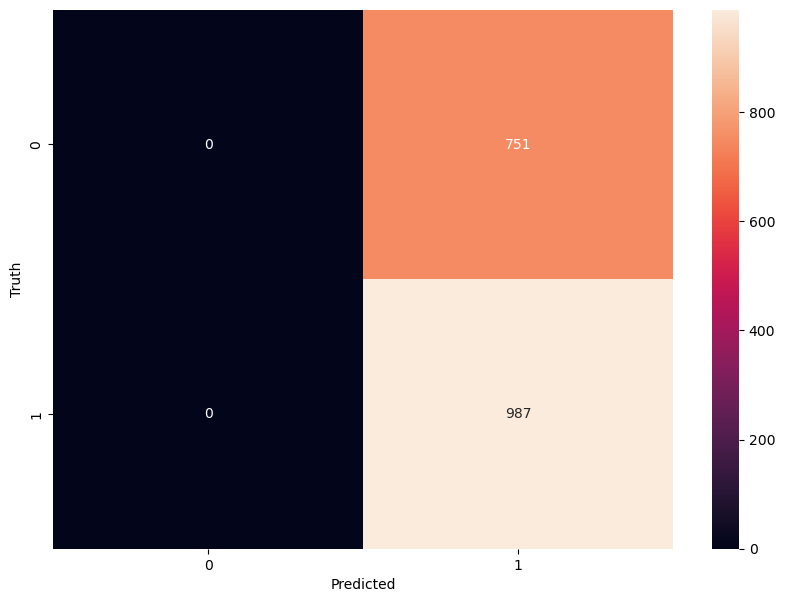

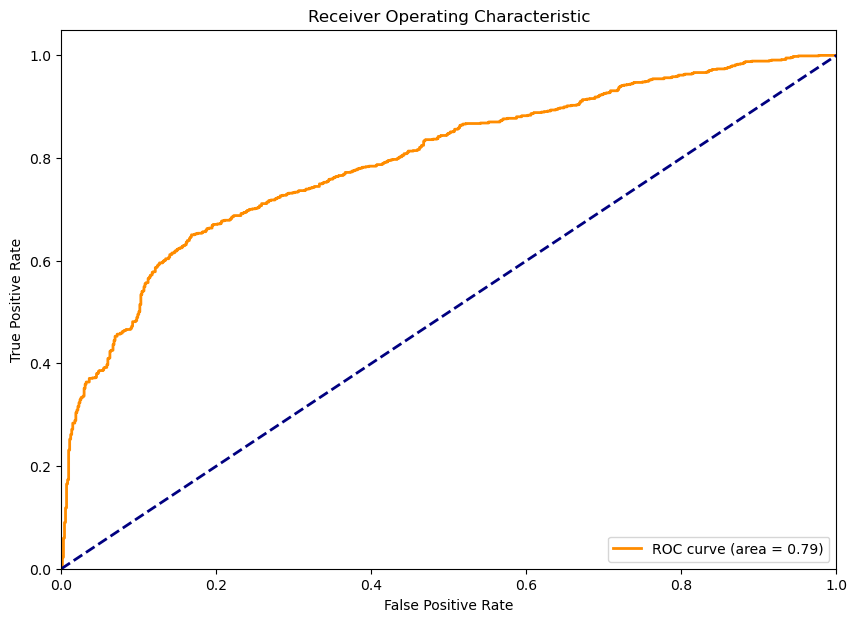

In [13]:
y_pred = model.predict(X_test)

y_pred = y_pred.max(axis=1).flatten()

# The model's output is continuous, but we need binary predictions for the metrics.
# We can choose a threshold (e.g., 0.5) and classify all instances with an output above this threshold as anomalies.
y_pred_bin = (y_pred > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_bin)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC (area under the ROC curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

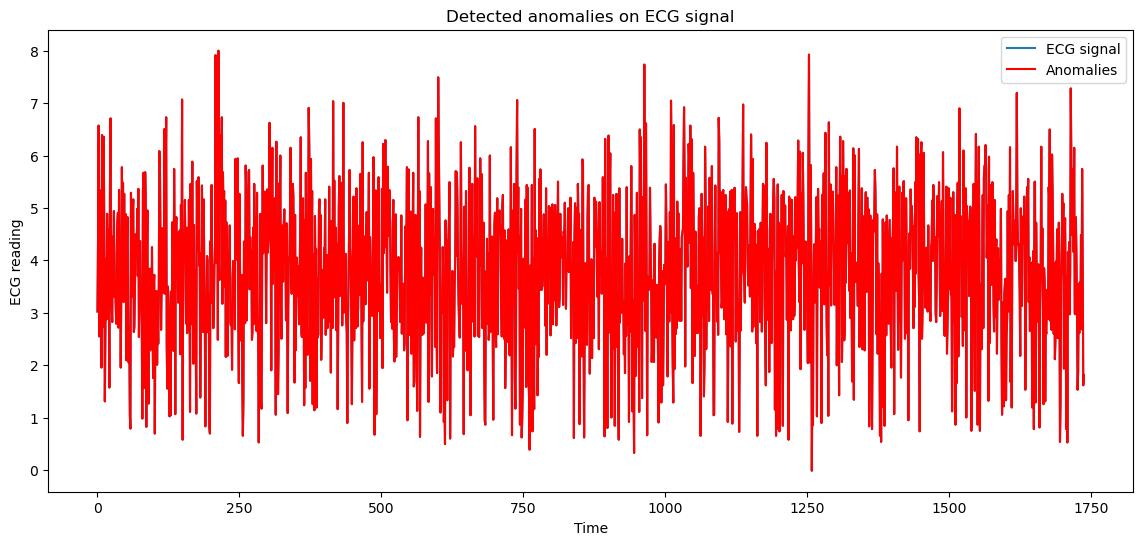

In [17]:
# Define the time variable
time = np.arange(len(X_test))

# Reshape the test data back to its original 2D shape
X_test_flattened = X_test.reshape(-1, X_test.shape[2])

# Assuming X_test_flattened now has shape (n_timesteps, n_features), and that the
# first feature is the ECG signal you want to plot
# Assuming the ECG signal is the first feature in X_test
ecg_signal_per_window = np.max(X_test[:, :, 0], axis=1)

# The time variable should now correspond to the number of windows, not the total number of time steps
time = np.arange(len(ecg_signal_per_window))

# Continue with the rest of your code
plt.figure(figsize=(14, 6))
plt.plot(time, ecg_signal_per_window, label='ECG signal')
anomalies = np.where(y_pred_bin == 1)
plt.plot(time[anomalies], ecg_signal_per_window[anomalies], 'r', label='Anomalies')
plt.title('Detected anomalies on ECG signal')
plt.xlabel('Time')
plt.ylabel('ECG reading')
plt.legend()
plt.show()